#Installing Dependencies

In [14]:
!pip install numpy pandas tensorflow nltk rouge-score python-docx

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# Language Model with Sequence Prediction

This notebook demonstrates the creation of a language model that predicts the next word in a sequence. It uses a variety of models such as SimpleRNN, LSTM, GRU, and BiLSTM. We also integrate word embeddings, preprocess text data, and evaluate the models on accuracy.

## Libraries and Setup

We begin by importing the necessary libraries and downloading required NLTK resources.

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Download NLTK resources (if not done already)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Word Embeddings
We load the word embeddings stored in a CSV file (word_embeddings.csv) and convert them into a dictionary for easy access.


In [37]:
# Load word embeddings (word_embeddings.csv)
embedding_df = pd.read_csv(r'/content/drive/MyDrive/Language_Model/word_embeddings.csv', index_col=0)
word_to_embedding = embedding_df.to_dict(orient='index')

# Preprocess Text Data
Next, we load the text data from a file and preprocess it. This involves tokenizing the sentences into words using NLTK's word tokenizer.

In [38]:
# Load and preprocess the merged text data
with open(r'/content/drive/MyDrive/Language_Model/merged_text (4).txt', 'r') as file:
    text_data = file.readlines()

# Tokenize the text (using nltk.word_tokenize for better tokenization)
def tokenize(text):
    return nltk.word_tokenize(text.lower())

tokenized_sentences = [tokenize(sentence) for sentence in text_data]

# Vocabulary Creation
We create a vocabulary by mapping words to unique token IDs. Unknown words are assigned a special <UNK> token, and padding tokens are also added.

In [39]:
all_words = [word for sentence in tokenized_sentences for word in sentence]
word_counts = Counter(all_words)
vocab = {word: idx + 1 for idx, (word, _) in enumerate(word_counts.items())}
vocab['<UNK>'] = 0  # For unknown words
vocab['<PAD>'] = len(vocab)  # Add padding token
idx_to_word = {idx: word for word, idx in vocab.items()}

#Convert Words to Token IDs
We convert each word in a sentence to its corresponding token ID. This step also prepares the sequences for padding.

In [40]:
def sentence_to_token_ids(sentence):
    return [vocab.get(word, vocab['<UNK>']) for word in sentence]

tokenized_ids = [sentence_to_token_ids(sentence) for sentence in tokenized_sentences]

# Padding Sequences
To make all sequences the same length, we use padding. The maximum sequence length is set to the length of the longest sentence in the dataset.

In [41]:
# Step 3: Pad sequences to the same length
max_sequence_length = max(len(sentence) for sentence in tokenized_ids)
X = pad_sequences(tokenized_ids, maxlen=max_sequence_length, padding='post')


#Prepare Target Labels
For next-word prediction, we create target labels by shifting the sentences by one word.

In [42]:
# Prepare the target labels (next word prediction)
next_words = [sentence[1:] for sentence in tokenized_ids]
X = X[:, :-1]  # Remove the last word from input
y = [sentence_to_token_ids(sentence[1:]) for sentence in tokenized_sentences]
y = pad_sequences(y, maxlen=max_sequence_length - 1, padding='post')

# Convert y to categorical (one-hot encoded)
y = [to_categorical(sentence, num_classes=len(vocab)) for sentence in y]

# Step 4: Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating Embedding Matrix

In [43]:
# Embedding parameters
embedding_dim = len(next(iter(word_to_embedding.values())))
embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, idx in vocab.items():
    if word in word_to_embedding:
        embedding_matrix[idx] = np.array(list(word_to_embedding[word].values()))
    else:
        embedding_matrix[idx] = np.zeros(embedding_dim)

# Model Configuration, Definition and Training

In [44]:
# Model configurations
model_configs = {
    'SimpleRNN': {'units': 32, 'dropout': 0.2, 'epochs': 5, 'batch_size': 32},
    'LSTM': {'units': 64, 'dropout': 0.3, 'epochs': 7, 'batch_size': 32},
    'GRU': {'units': 64, 'dropout': 0.2, 'epochs': 8, 'batch_size': 32},
    'BiLSTM': {'units': 64, 'dropout': 0.3, 'epochs': 5, 'batch_size': 32}
}

# Define and train models
def create_and_train_model(model_type, config):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=len(vocab), output_dim=embedding_dim, weights=[embedding_matrix], trainable=False))
    if model_type == 'SimpleRNN':
        model.add(tf.keras.layers.SimpleRNN(config['units'], return_sequences=True))
    elif model_type == 'LSTM':
        model.add(tf.keras.layers.LSTM(config['units'], return_sequences=True))
    elif model_type == 'GRU':
        model.add(tf.keras.layers.GRU(config['units'], return_sequences=True))
    elif model_type == 'BiLSTM':
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config['units'], return_sequences=True)))
    model.add(tf.keras.layers.Dropout(config['dropout']))
    model.add(tf.keras.layers.Dense(len(vocab), activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, np.array(y_train), epochs=config['epochs'], batch_size=config['batch_size'], validation_data=(X_val, np.array(y_val)))
    return model, history

# Function to plot metrics

In [45]:
def plot_metrics(history, model_name):
    # Training and Validation Loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to generate text based on a model


Training SimpleRNN with configuration: {'units': 32, 'dropout': 0.2, 'epochs': 5, 'batch_size': 32}
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3818 - loss: 7.6955 - val_accuracy: 0.0091 - val_loss: 7.6240
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 364ms/step - accuracy: 0.0803 - loss: 7.6045 - val_accuracy: 0.8711 - val_loss: 7.5393
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.6274 - loss: 7.5123 - val_accuracy: 0.8742 - val_loss: 7.4358
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.9015 - loss: 7.3985 - val_accuracy: 0.8753 - val_loss: 7.3127
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.9289 - loss: 7.2650 - val_accuracy: 0.8751 - val_loss: 7.1689


SimpleRNN model saved!
Generated text using SimpleRNN:
The future of AI
Reference Text: The future of AI is exciting and filled with possibilities.
BLEU Score for SimpleRNN: 0.1738
ROUGE Scores for SimpleRNN: {'rouge1': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rouge2': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715)}


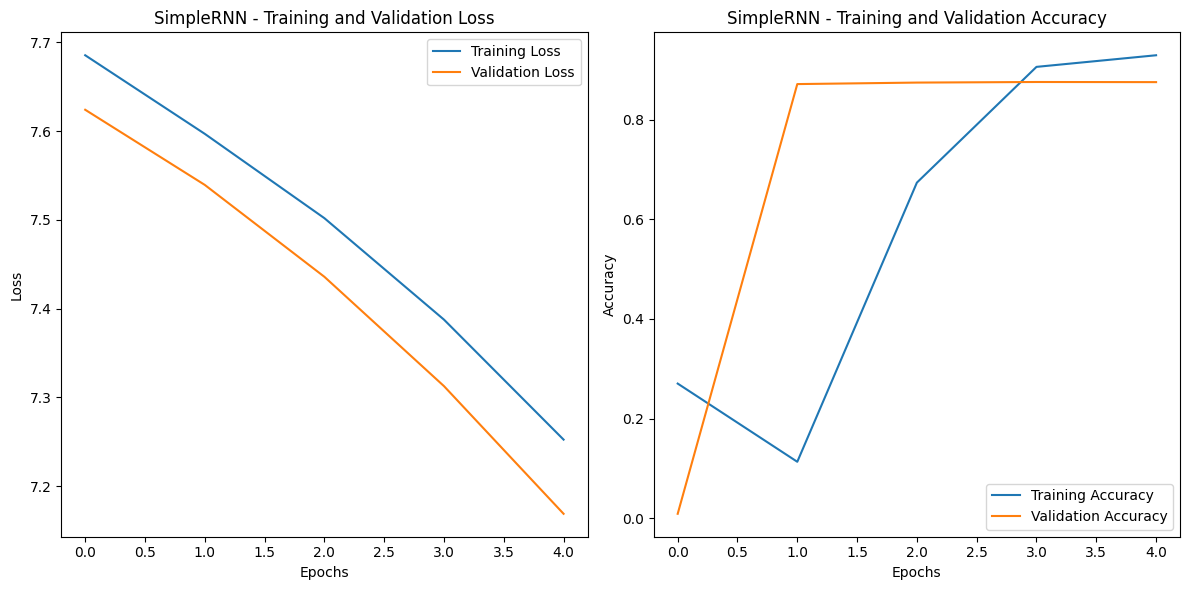


Training LSTM with configuration: {'units': 64, 'dropout': 0.3, 'epochs': 7, 'batch_size': 32}
Epoch 1/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 690ms/step - accuracy: 0.9127 - loss: 7.7154 - val_accuracy: 0.8725 - val_loss: 7.7049
Epoch 2/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - accuracy: 0.9288 - loss: 7.7016 - val_accuracy: 0.8758 - val_loss: 7.6852
Epoch 3/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 0.9237 - loss: 7.6785 - val_accuracy: 0.8756 - val_loss: 7.6434
Epoch 4/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.9350 - loss: 7.6239 - val_accuracy: 0.8740 - val_loss: 7.4949
Epoch 5/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.9295 - loss: 7.4164 - val_accuracy: 0.8738 - val_loss: 7.0747
Epoch 6/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.9396 - loss: 6.9542 - val_accuracy: 0.8738 - val_loss: 6.6201
Epoch 7/7
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - accuracy: 0.9346 - loss: 6.4817 - val_accuracy: 0.8738 - val_loss: 6.1887


LSTM model saved!
Generated text using LSTM:
The future of AI
Reference Text: The future of AI is exciting and filled with possibilities.
BLEU Score for LSTM: 0.1738
ROUGE Scores for LSTM: {'rouge1': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rouge2': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715)}


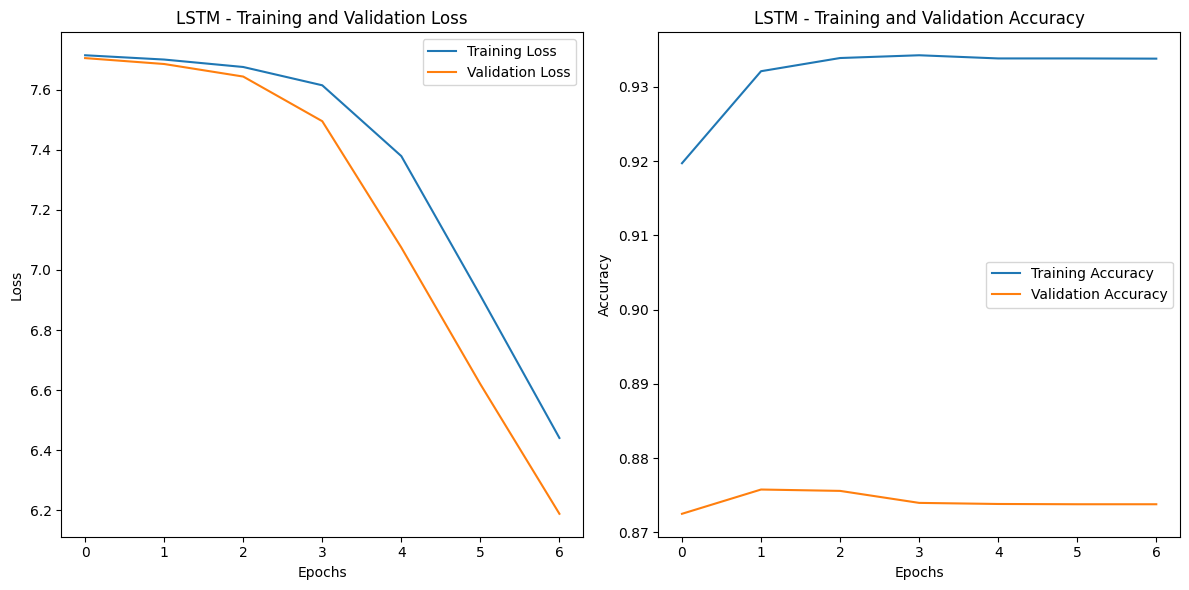


Training GRU with configuration: {'units': 64, 'dropout': 0.2, 'epochs': 8, 'batch_size': 32}
Epoch 1/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 672ms/step - accuracy: 0.9326 - loss: 7.7151 - val_accuracy: 0.8732 - val_loss: 7.7034
Epoch 2/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.9331 - loss: 7.7001 - val_accuracy: 0.8739 - val_loss: 7.6853
Epoch 3/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step - accuracy: 0.9390 - loss: 7.6805 - val_accuracy: 0.8751 - val_loss: 7.6605
Epoch 4/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - accuracy: 0.9237 - loss: 7.6531 - val_accuracy: 0.8757 - val_loss: 7.6246
Epoch 5/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.9332 - loss: 7.6126 - val_accuracy: 0.8755 - val_loss: 7.5691
Epoch 6/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.9413 - loss: 7.5483 - val_accuracy: 0.8750 - val_loss: 7.4749
Epoch 7/8
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.9330 - loss: 7.4372 - val_accuracy: 0.8743 - val_loss: 7.2846
Epoch 8/8
3/3 ━━━━━━━━━━━━━━━━

GRU model saved!
Generated text using GRU:
The future of AI
Reference Text: The future of AI is exciting and filled with possibilities.
BLEU Score for GRU: 0.1738
ROUGE Scores for GRU: {'rouge1': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rouge2': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715)}


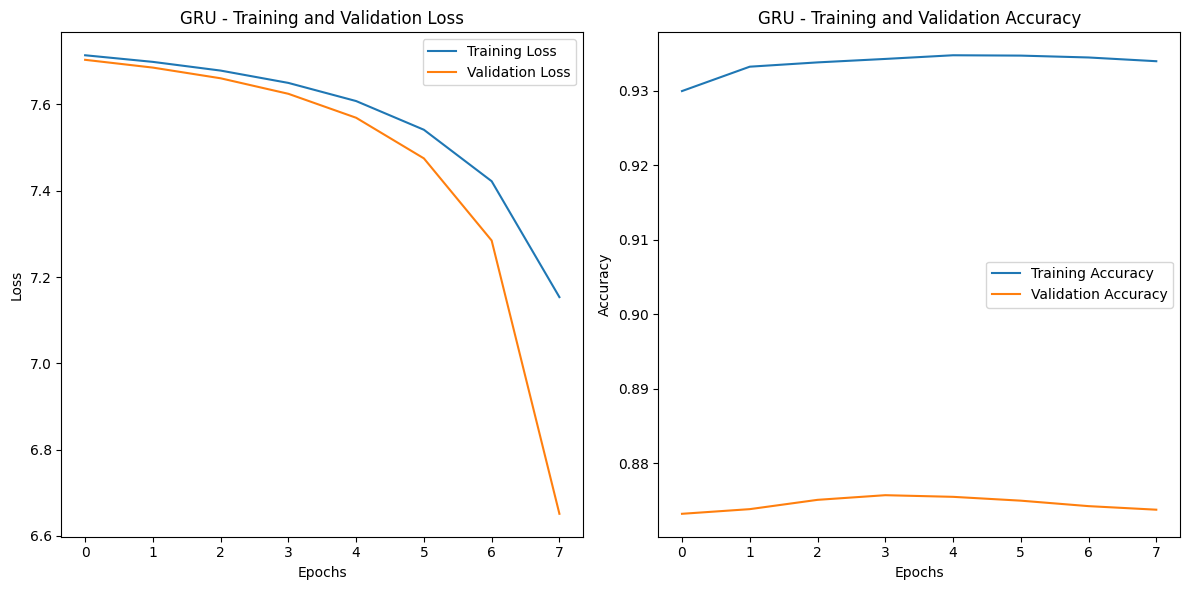


Training BiLSTM with configuration: {'units': 64, 'dropout': 0.3, 'epochs': 5, 'batch_size': 32}
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 762ms/step - accuracy: 0.9216 - loss: 7.7144 - val_accuracy: 0.8739 - val_loss: 7.6988
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - accuracy: 0.9370 - loss: 7.6946 - val_accuracy: 0.8769 - val_loss: 7.6709
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step - accuracy: 0.9236 - loss: 7.6628 - val_accuracy: 0.8773 - val_loss: 7.6198
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.9419 - loss: 7.6010 - val_accuracy: 0.8746 - val_loss: 7.4953
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.9340 - loss: 7.4281 - val_accuracy: 0.8739 - val_loss: 6.9128


BiLSTM model saved!
Generated text using BiLSTM:
The future of AI
Reference Text: The future of AI is exciting and filled with possibilities.
BLEU Score for BiLSTM: 0.1738
ROUGE Scores for BiLSTM: {'rouge1': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rouge2': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715)}


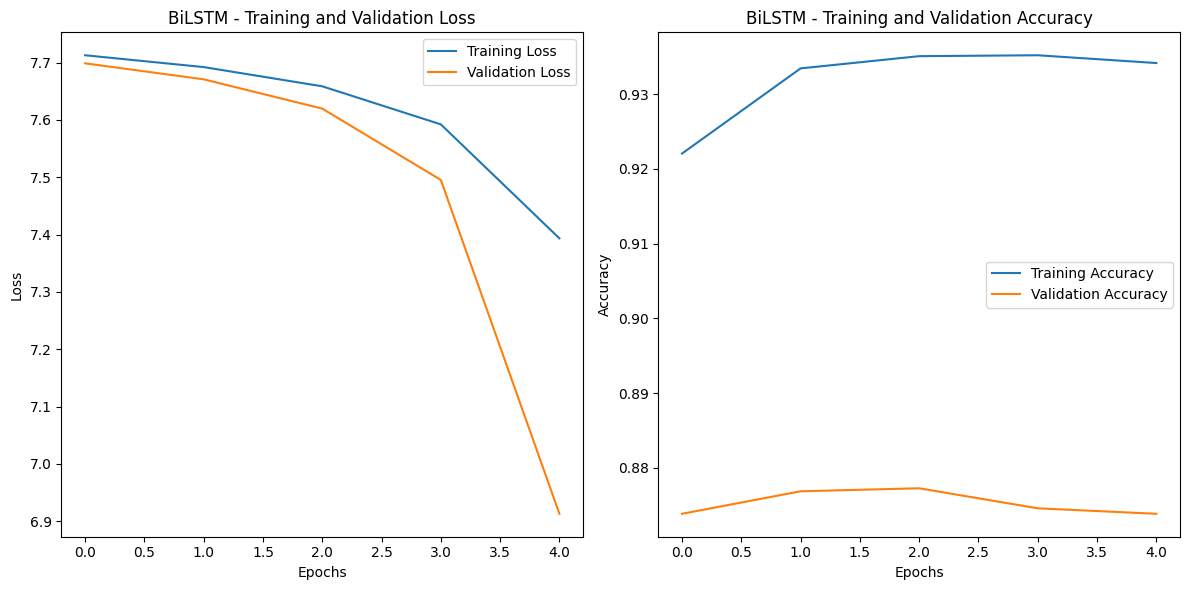


Model: SimpleRNN
Hyperparameters: {'units': 32, 'dropout': 0.2, 'epochs': 5, 'batch_size': 32}
Training Accuracy: 0.9290
Validation Accuracy: 0.8751
Training Loss: 7.2524
Validation Loss: 7.1689
BLEU Score: 0.1738
ROUGE Scores: {'rouge1': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rouge2': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715)}

Model: LSTM
Hyperparameters: {'units': 64, 'dropout': 0.3, 'epochs': 7, 'batch_size': 32}
Training Accuracy: 0.9338
Validation Accuracy: 0.8738
Training Loss: 6.4410
Validation Loss: 6.1887
BLEU Score: 0.1738
ROUGE Scores: {'rouge1': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715), 'rouge2': Score(precision=1.0, recall=0.3333333333333333, fmeasure=0.5), 'rougeL': Score(precision=1.0, recall=0.4, fmeasure=0.5714285714285715)}

Model: GRU
Hyperparameters: {'units': 64, 'dropout': 0.2, 'epochs': 8, 'batch_size': 32}
Training Accuracy

In [47]:
# Function to generate text based on a model
def generate_text(model, seed_text, max_sequence_length, num_words=50):
    tokenized_seed = tokenize(seed_text)
    tokenized_seed_ids = sentence_to_token_ids(tokenized_seed)
    tokenized_seed_ids = pad_sequences([tokenized_seed_ids], maxlen=max_sequence_length - 1, padding='post')

    generated_text = seed_text
    for _ in range(num_words):
        pred_probs = model.predict(tokenized_seed_ids, verbose=0)
        pred_word_id = np.argmax(pred_probs[0, -1, :])
        pred_word = idx_to_word.get(pred_word_id, '<UNK>')

        if pred_word == '<PAD>' or pred_word == '<UNK>':
            continue

        generated_text += ' ' + pred_word
        tokenized_seed_ids = np.append(tokenized_seed_ids, [[pred_word_id]], axis=1)
        tokenized_seed_ids = tokenized_seed_ids[:, 1:]

    return generated_text

# Calculate BLEU score
def calculate_bleu(reference, candidate):
    reference = [tokenize(reference.lower())]
    candidate = tokenize(candidate.lower())
    return sentence_bleu(reference, candidate)

# Calculate ROUGE score
def calculate_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return scores

# Train and evaluate all models
results = {}
for model_name, config in model_configs.items():
    print(f"\nTraining {model_name} with configuration: {config}")
    model, history = create_and_train_model(model_name, config)

    # Save the trained model
    model.save(f'{model_name}_model.h5')
    print(f'{model_name} model saved!')

    # Generate text using the trained model
    seed_text = "The future of AI"
    generated_text = generate_text(model, seed_text, max_sequence_length)
    print(f"Generated text using {model_name}:")
    print(generated_text)

    # Compute BLEU and ROUGE scores
    reference_text = "The future of AI is exciting and filled with possibilities."
    print(f"Reference Text: {reference_text}")
    bleu_score = calculate_bleu(reference_text, generated_text)
    rouge_scores = calculate_rouge(reference_text, generated_text)

    print(f"BLEU Score for {model_name}: {bleu_score:.4f}")
    print(f"ROUGE Scores for {model_name}: {rouge_scores}")

    # Plot the graphs for each model
    plot_metrics(history, model_name)

    # Final accuracy and loss
    final_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]
    final_loss = history.history['loss'][-1]  # Training loss
    final_val_loss = history.history['val_loss'][-1]  # Validation loss

    results[model_name] = {
        'Hyperparameters': config,
        'Final_Training_Accuracy': final_accuracy,
        'Final_Validation_Accuracy': final_val_accuracy,
        'Final_Training_Loss': final_loss,
        'Final_Validation_Loss': final_val_loss,
        'BLEU_Score': bleu_score,
        'ROUGE_Scores': rouge_scores
    }

# Print summary of results
for model, result in results.items():
    print(f"\nModel: {model}")
    print(f"Hyperparameters: {result['Hyperparameters']}")
    print(f"Training Accuracy: {result['Final_Training_Accuracy']:.4f}")
    print(f"Validation Accuracy: {result['Final_Validation_Accuracy']:.4f}")
    print(f"Training Loss: {result['Final_Training_Loss']:.4f}")
    print(f"Validation Loss: {result['Final_Validation_Loss']:.4f}")
    print(f"BLEU Score: {result['BLEU_Score']:.4f}")
    print(f"ROUGE Scores: {result['ROUGE_Scores']}")